# Advantage Actor-Critic

In [1]:
%load_ext autoreload
%autoreload 2
import gym
import time
import threading
import numpy as np
import ipywidgets as widgets
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import layers

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.enable_eager_execution(config=config)

## Critic Model

First, we define the critic.  This model will recieve the observation as input and will return the value of the given state.
<br>It's initialized with the size of the observation vector and the size of the action vector.
<br>It's comprised of two hidden dense layers of size 128 with relu activations and a dense output layer of size 1.

In [2]:
class CriticModel(keras.Model):
    def __init__(self, observation_size, action_size):
        super(CriticModel, self).__init__()
        self.observation_size = observation_size
        self.action_size = action_size
        
        self.value_dense_1 = layers.Dense(128, activation='relu')
        self.value_dense_2 = layers.Dense(128, activation='relu')
        self.values = layers.Dense(1)

    def call(self, inputs):
        input_tensor = tf.convert_to_tensor(inputs, dtype=tf.float32)
        y = self.value_dense_1(input_tensor)
        y = self.value_dense_2(y)
        values = self.values(y)
        return values

We can quickly test to see if our critic can learn a basic XOR dataset.  First, we create the XOR data and initialize our critic.

In [3]:
input_data = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])

output_data = np.array([
    [0],
    [1],
    [1],
    [0]
])

critic = CriticModel(len(input_data[0]), len(output_data[0]))

Next, we perform backpropagation to train the critic.  First, we pass the XOR input data through the critic to perform forward propagation, then we calculate the negative MSE of the actual XOR output data and the critic's output.  We perform both of these operations within the `GradientTape` context manager, which records operations for automatic differentiation.  
We can then call the resulting `tape.gradient` method with the loss and weights we want to recieve the gradients for (i.e., the critic's trainable_weights).  This gives us back the gradients as tensors.  We can then iterate through the gradients and the critic's corresponding weights and add the gradients (multiplied by our learning rate `lr`) to the weights.

This will complete one iteration of backpropagation for our critic.  We repeat this process for `epochs` iterations, which should result in fairly accurate results.

https://www.tensorflow.org/api_docs/python/tf/GradientTape

- critic_loss:
 tf.Tensor(-0.0018612146, shape=(), dtype=float32)

- output_data:
 [[0]
 [1]
 [1]
 [0]]

- values:
 tf.Tensor(
[[0.0363331 ]
 [0.98604023]
 [0.9834815 ]
 [0.00856652]], shape=(4, 1), dtype=float32)



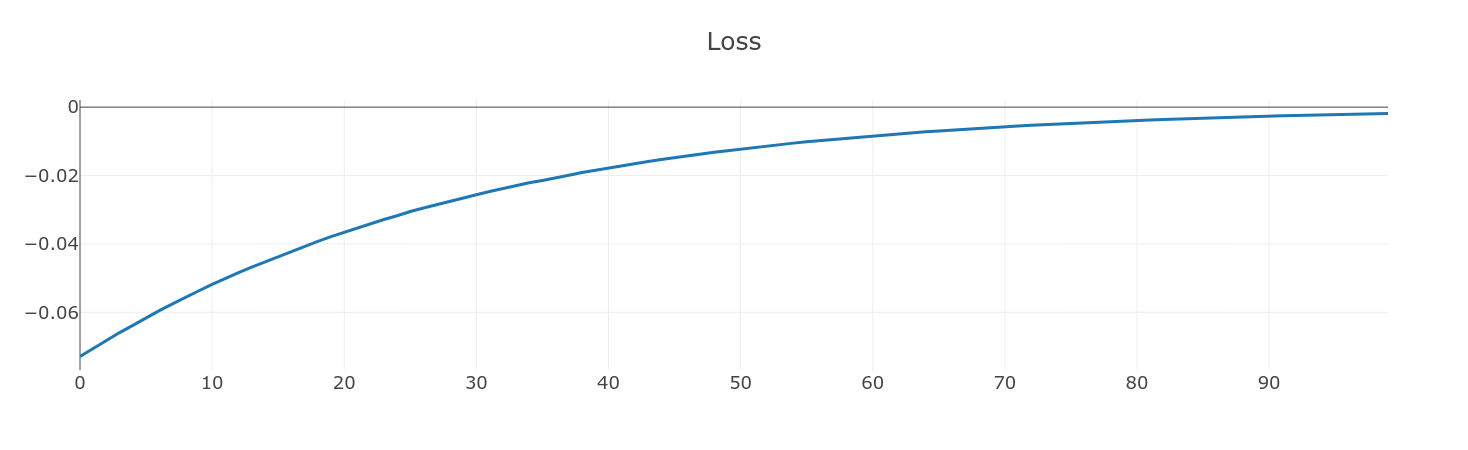

In [5]:
lr = 0.01
epochs = 100
losses = []

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        values = critic(input_data)
        critic_loss = -tf.reduce_sum((output_data - values)**2)

    losses.append(float(critic_loss))
    critic_grads = tape.gradient(critic_loss, critic.trainable_weights)
    for w, g in zip(critic.trainable_weights, critic_grads):
        w.assign_add(lr * g)

print('- critic_loss:\n', critic_loss)
print('\n- output_data:\n', output_data)
print('\n- values:\n', values)
print()

plotly.offline.iplot({
    "data": [go.Scatter(x=np.arange(len(losses)), y=losses)],
    "layout": go.Layout(title="Loss", template="presentation")
})

In the above example, the critic is learning a finite, arbitrary mapping.  In our application, we want the critic to be able to accurately predict the expected future discounted rewards for a given state (i.e., our value).  In essense, it's the same task as above, but instead of learning a mapping from input data to output data, we instead generate the input data by stepping through an environment (i.e., _observations_) and calculate the true discounted future rewards per episode, then learn the mapping between the two.

To demonstrate this process, we will construct a simple example.  Consider an environment with `no_states` different states, and a policy $\pi$ which will simulate an ideal agent's policy.  So, for every state the "agent" passes through, the agent will net a reward of `1`.  If an episode consists of 3 states, then we expect the total net reward to be `3` (+ `1` for each state).  This means that, with a discounting factor $\gamma = 0.99$, we can compute discounted future rewards with the following function:

In [6]:
def get_discounted_rewards(rewards, gamma=0.99):
    discounted_rewards = []
    reward_sum = 0
    for reward in rewards[::-1]:
        reward_sum = reward + gamma * reward_sum
        discounted_rewards.append(reward_sum)
    discounted_rewards.reverse()
    return discounted_rewards

get_discounted_rewards([1, 1, 1])

[2.9701, 1.99, 1.0]

So, in the first state, we expect our critic to learn that our future discounted rewards to be `2.9701`, then `1.99` for the second state, then `1.0` for the last state.  We can see in the following example that our critic can learn this fairly quickly.

- critic_loss:
 tf.Tensor(-0.00019192709, shape=(), dtype=float32)

- observations:
 tf.Tensor(
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]], shape=(3, 3), dtype=float32)

- discounted_rewards:
 [[2.9701]
 [1.99  ]
 [1.    ]]

- values:
 tf.Tensor(
[[2.9650676]
 [1.9876015]
 [1.0126827]], shape=(3, 1), dtype=float32)



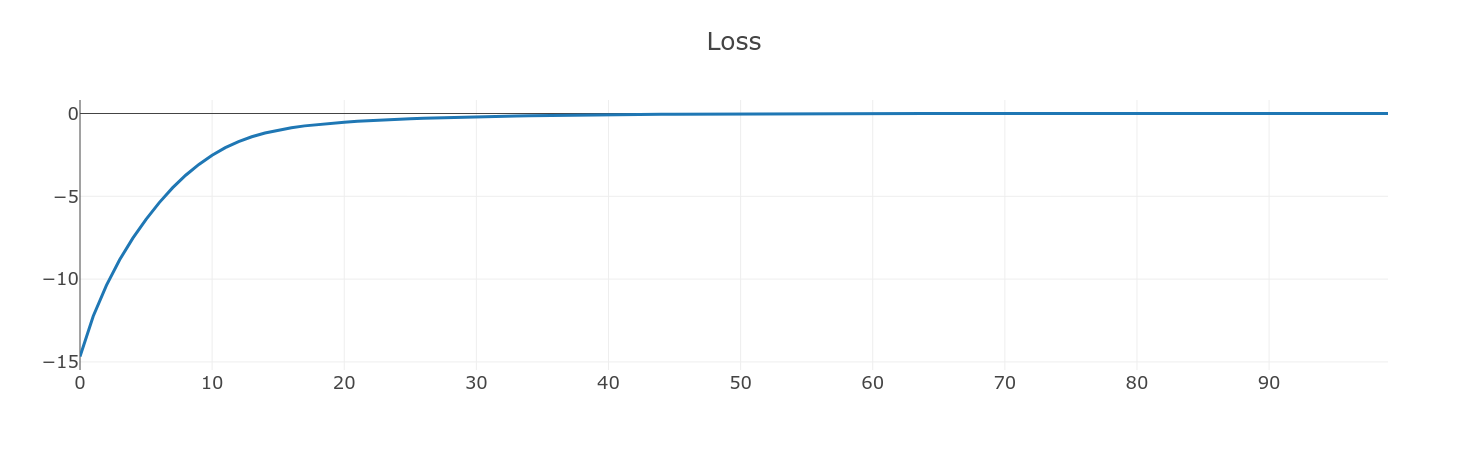

In [8]:
no_states = 3
critic = CriticModel(len(input_data[0]), len(output_data[0]))
observations = tf.one_hot(np.arange(no_states), no_states)
discounted_rewards = np.array(get_discounted_rewards([1, 1, 1])).reshape(no_states, 1)
losses = []

lr = 0.005
epochs = 100
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        values = critic(observations)
        critic_loss = -tf.reduce_sum((discounted_rewards - values)**2)

    losses.append(float(critic_loss))
    critic_grads = tape.gradient(critic_loss, critic.trainable_weights)
    for w, g in zip(critic.trainable_weights, critic_grads):
        w.assign_add(lr * g)
        
print('- critic_loss:\n', critic_loss)
print('\n- observations:\n', observations)
print('\n- discounted_rewards:\n', discounted_rewards)
print('\n- values:\n', values)
print()
plotly.offline.iplot({
    "data": [go.Scatter(x=np.arange(len(losses)), y=losses)],
    "layout": go.Layout(title="Loss", template="presentation")
})

## Actor Model

Next, we define the actor.  This model will recieve the observation as input and will return the probability distribution of the actions for the given state.
<br>It's initialized with the size of the observation vector and the size of the action vector.
<br>It's comprised of two hidden dense layers of size 128 with relu activations and a dense output layer of size `action_size`.

In [9]:
class ActorModel(keras.Model):
    def __init__(self, observation_size, action_size):
        super(ActorModel, self).__init__()
        self.observation_size = observation_size
        self.action_size = action_size
        
        self.policy_dense_1 = layers.Dense(128, activation='relu')
        self.policy_dense_2 = layers.Dense(128, activation='relu')
        self.policy_logits = layers.Dense(action_size)

    def call(self, inputs):
        input_tensor = tf.convert_to_tensor(inputs, dtype=tf.float32)
        x = self.policy_dense_1(input_tensor)
        x = self.policy_dense_2(x)
        logits = self.policy_logits(x)
        return logits

# Actor-Critic Model

Finally, we combine the previous two models to build our Actor-Critic model.  Here, the goal is to leverage the value-predicting power of the critic to approximate a given actions _advantage_, which will help us guide the actor to finding an optimal policy.

In [10]:
class ActorCriticModel(keras.Model):
    def __init__(self, observation_size, action_size):
        super(ActorCriticModel, self).__init__()
        self.observation_size = observation_size
        self.action_size = action_size
        self.actor = ActorModel(observation_size, action_size)
        self.critic = CriticModel(observation_size, action_size)
        
    def call(self, inputs):
        return self.actor(inputs), self.critic(inputs)

class HyperParameters:
    def __init__(self, **kw):
        self.gamma = 0.99
        self.vf_coef = 0.5
        self.ent_coef = 0.01
        self.lr = 0.001
        self.__dict__.update(kw)
        
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

Similar to our previous examples, we define our agent's loss function.  This time, however, we combine the loss from both the critic and the actor.  This allows us to train both at the same time.

Note: Along with the critic's mean squared error and the actor's cross-entropy, we also incorporate two more features: _entropy_ and _discounted reward normalization_.

Entropy is used to promote the actor's exploration by penalizing the actor for having a narrow distribution (i.e., being overly confident in a single action for a given observation).  An interesting discussion on this can be found here:

https://github.com/dennybritz/reinforcement-learning/issues/34

Discounted Reward Normalization is used for stability purposes.  In theory, we don't need to normalize discounted rewards, but due to the variance in environment's rewards (e.g., one environment can end up with total rewards ranging between -10 and 10, while another ranges between 100 and 1000), we take a safe approach and normalize these rewards.  A discussion on this can be found here:

https://datascience.stackexchange.com/questions/20098/why-do-we-normalize-the-discounted-rewards-when-doing-policy-gradient-reinforcem

In [11]:
def loss(a2c, observations, actions, discounted_rewards, hyperparameters, verbose=False, normalize_discounted_rewards=True, *args, **kargs):
    hp = hyperparameters
    
    logits, values = a2c(tf.convert_to_tensor(observations, dtype=tf.float32))
    values = tf.squeeze(values)

    if normalize_discounted_rewards:
        discounted_rewards -= np.mean(discounted_rewards)
        discounted_rewards /= np.std(discounted_rewards)

    discounted_rewards = tf.convert_to_tensor(np.array(discounted_rewards), dtype=tf.float32)
    advantages =  tf.stop_gradient(discounted_rewards) - values

    critic_loss = advantages ** 2

    policy = tf.nn.softmax(logits)
    entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=policy, logits=logits)

    actor_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=actions, logits=logits)
    actor_loss *= tf.stop_gradient(advantages)
    actor_loss -= hp.ent_coef * entropy

    total_loss = tf.reduce_mean(hp.vf_coef * critic_loss + actor_loss)

    if verbose:
        variables = dir()[:]
        for key in variables:
            print(key)
            print(locals()[key])
    
    return total_loss

We also define a "runner" function which performs the operations of a Markov Decision Process:

https://towardsdatascience.com/reinforcement-learning-demystified-markov-decision-processes-part-1-bf00dda41690

Basically, this works by having passing the current observation from our environment to our agent, having our agent produce an action based on the observation and passing that back to the environment, then having the environment produce the next state (and repeat).  Along the way, we capture data (such as the observations, rewards, and actions) in batches to train on later.  After our batch grows large enough, we train our agent on the data, then continue with the process.

In [12]:
def run(env, a2c, verbose=False, *args, **kargs):
    obs = env.reset()
    done = False
    rewards = []
    actions = []
    observations = []
        
    while not done:
        logits, _ = a2c(tf.convert_to_tensor(obs[None, :], dtype=tf.float32))
        probs = tf.nn.softmax(logits)
        action = np.random.choice(env.action_space.n, p=probs.numpy()[0])

        next_obs, reward, done, info = env.step(action)
        
        if done:
            reward = -1
        
        observations.append(obs)
        actions.append(action)
        rewards.append(reward)
        
        obs = next_obs
        total_reward = np.sum(rewards)
        
        if verbose:
            variables = dir()[:]
            for key in variables:
                print(key)
                print(locals()[key])
            
        if done:
            return observations, actions, rewards

We also provide a _learn_ function which will recive the data, create an Adam Optimizer, and train the agent.

In [13]:
def learn(a2c, observations, actions, discounted_rewards, hyperparameters, *args, **kargs):
    opt = tf.train.AdamOptimizer(hp.lr, use_locking=True)
    with tf.GradientTape() as tape:
        total_loss = loss(a2c, observations, actions, discounted_rewards, hyperparameters=hp, **kargs)

    grads = tape.gradient(total_loss, a2c.trainable_weights)
    opt.apply_gradients(zip(grads, a2c.trainable_weights))

With that all defined, we now call an OpenAI gym environment and create an Advantage Actor-Critic agent that we will be training.

OpenAI Gym is a framework used to build environments compatible with this kind of learning process.  Although Gym environments range everywhere from complex physics simulations to Atari games, they supply a couple of methods that are consistent for every environment.  These are the `step` method (which accepts and action and returns the resulting observation for the next state, the reward, whether or not the environment is done, and any extra info) and the `reset` method (which resets an environment to an initial state).  More info on Gym can be found here:

https://gym.openai.com/

We start with a simple environment, `CartPole-v1`.  Details on this environment can be found here:

https://gym.openai.com/envs/CartPole-v1/

In [14]:
env = gym.make('CartPole-v1')
#env = gym.make('LunarLander-v2')
a2c = ActorCriticModel(env.observation_space.shape[0], env.action_space.n)
a2c(tf.convert_to_tensor(np.random.random((1, a2c.observation_size)), dtype=tf.float32))

(<tf.Tensor: id=29324, shape=(1, 2), dtype=float32, numpy=array([[0.00073717, 0.08373708]], dtype=float32)>,
 <tf.Tensor: id=29410, shape=(1, 1), dtype=float32, numpy=array([[0.00830825]], dtype=float32)>)

Finally, we learn from the environment.  There are many hyperparameters that can be adjusted, from coefficients used during training to the number of episodes we run through.

We run through each episode, collecting data into our batch.  Once our batch grows large enough (e.g., to 512 observations), we train the agent on the batch.  Once it's trained, we clear the batch and start again.

In [15]:
hp = HyperParameters(gamma = 0.99, vf_coef = 0.5, ent_coef = 0.001, lr = 0.001)

start_time = time.time()
batch = {
    "observations": [],
    "actions": [],
    "discounted_rewards": []
}

ep_rewards = []
episodes = 100
episode = 0
epochs = 8
batch_size = 512
while episode < episodes:
    observations, actions, rewards = run(env, a2c, verbose=0)
    ep_rewards.append(np.sum(rewards))
    
    # Calculate True Discounted Rewards
    discounted_rewards = get_discounted_rewards(rewards, hp.gamma)
    
    batch['observations'] += observations
    batch['actions'] += actions
    batch['discounted_rewards'] += discounted_rewards

    if len(batch['observations']) >= batch_size:
        print(f"Ep {episode} ({time.time() - start_time:.3f}s): {np.mean(ep_rewards[-10:])}")
        for epoch in range(epochs):
            learn(a2c, hyperparameters=hp, lock_actor=True, **batch)
        batch = {
            "observations": [],
            "actions": [],
            "discounted_rewards": []
        }
    episode += 1
    
end_time = time.time()
print(end_time - start_time)

Ep 18 (0.389s): 23.3
Ep 31 (1.096s): 38.9
Ep 43 (1.809s): 42.9
Ep 49 (2.512s): 66.4
Ep 52 (3.228s): 108.9
Ep 59 (4.014s): 112.6
Ep 61 (5.118s): 174.6
Ep 64 (6.018s): 210.9
Ep 67 (6.778s): 243.4
Ep 70 (7.704s): 248.1
Ep 72 (8.757s): 261.5
Ep 75 (9.564s): 255.0
Ep 77 (10.510s): 290.9
Ep 84 (11.344s): 140.7
Ep 86 (12.190s): 137.4
Ep 88 (13.168s): 179.0
Ep 90 (14.357s): 264.8
Ep 94 (15.284s): 293.4
Ep 96 (16.415s): 327.4
17.199629068374634


And, finally, we can plot our agent's training process.  The x-axis is the environment episode, while the y-axis is the total reward for the given episode.  We smooth the curve with a moving average.

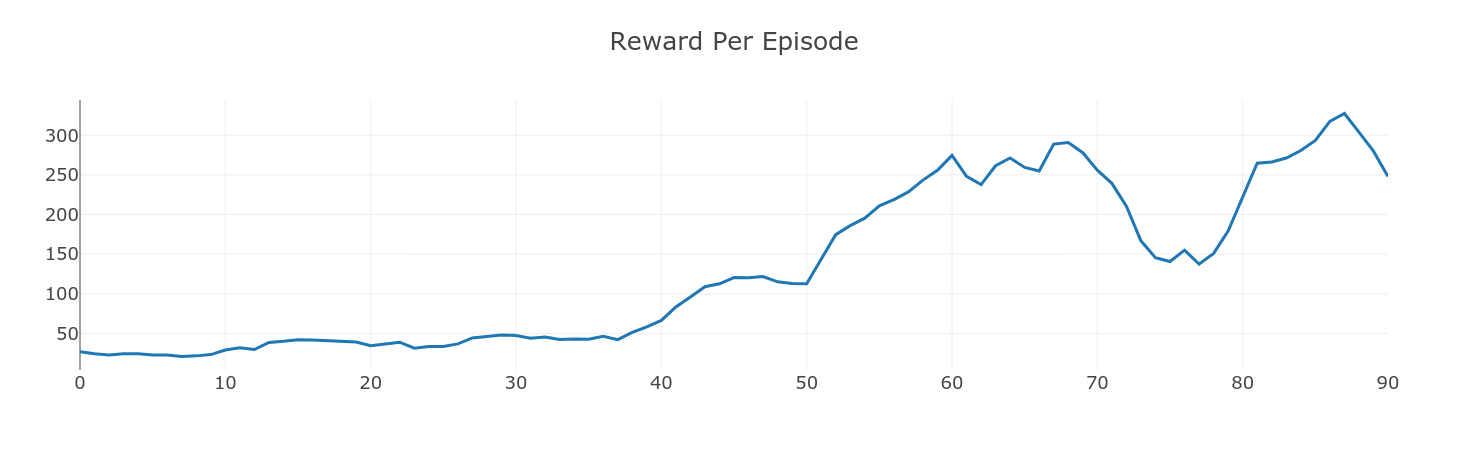

In [16]:
plotly.offline.iplot({
    "data": [go.Scatter(x=np.arange(len(ep_rewards)), y=moving_average(ep_rewards, 10))],
    "layout": go.Layout(title="Reward Per Episode", template="presentation")
})